In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction='in')
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in') 

        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [4]:
leda = pd.read_csv('Leda_bar.csv', delimiter='|')
leda = leda.set_index('PGC')

print(len(leda))

133229


/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (69,70,71,72,73,74,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df = pd.read_csv('ALLcf3SNIa.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())

df['pgc'] = df['PGC']
df_ALLcf3SNIa = df.set_index('PGC')

df_ALLcf3SNIa["PGC1"] = df_ALLcf3SNIa.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.pgc, axis=1)


df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"Vcmb": "Vcmb_ALLcf3SNIa"})
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"PGC1": "PGC1_ALLcf3SNIa"})
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"SGL": "SGL_ALLcf3SNIa"})
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"SGB": "SGB_ALLcf3SNIa"})

print(len(df_ALLcf3SNIa))

df_ALLcf3SNIa.head()

389


,PGC1_ALLcf3SNIa,Nest,Dist,Name,RAJ,DeJ,Glon,Glat,SGL_ALLcf3SNIa,SGB_ALLcf3SNIa,...,DMu,eDMu,DMj,eDMj,DMp,eDMp,DMh,DMf,NBG_ID,pgc
PGC,,,,,,,,,,,,,,,,,,,,,
250,250,208532,96.5,UGC00014,335.0,231202.9,108.8693,-38.3606,316.3211,17.6720,...,34.34,0.18,0.00,0.00,0.00,0.00,34.35,0.0,NaN,250
282,282,0,154.8,M-02-01-14,401.9,-111007.0,85.7160,-70.5385,282.0792,8.9702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282
415,415,200542,100.7,UGC00040,548.4,272656.6,110.6597,-34.3329,320.8087,17.8681,...,34.44,0.19,0.00,0.00,0.00,0.00,34.49,0.0,NaN,415
515,515,210067,71.4,UGC00052,649.5,83742.7,104.5597,-52.6445,301.6830,13.8439,...,33.70,0.21,0.00,0.00,0.00,0.00,33.68,0.0,NaN,515
963,963,211877,46.3,UGC00139,1431.9,-4415.6,102.8519,-62.1619,292.9641,9.5361,...,32.64,0.28,32.87,0.22,32.74,0.05,0.00,0.0,NaN,963


In [6]:
df = pd.read_csv('ScolnicSNIa3Tables.csv', delimiter='|')

df = df.rename(columns=lambda x: x.strip())
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)

df_scolnic = df.set_index('PGC')

df_scolnic["Vcmb_scolnic"] = Vh2V3k(df_scolnic["Glon"], df_scolnic["Glat"], df_scolnic["Vhel"])
df_scolnic = df_scolnic.rename(columns={"SGL": "SGL_scolnic"})
df_scolnic = df_scolnic.rename(columns={"SGB": "SGB_scolnic"})
df_scolnic = df_scolnic.rename(columns={"PGC1": "PGC1_scolnic"})

df_scolnic.head()

,SNIa,PGC1_scolnic,Nest,Tab,DM,DMp,eDMp,DM18,eDM18,DM17,eDM17,Vhel,Vsn,Glon,Glat,SGL_scolnic,SGB_scolnic,Vcmb_scolnic
PGC,,,,,,,,,,,,,,,,,,
250,2006sr,250,208532,1,35.061,35.061,0.133,35.057,0.102,35.046,0.079,7253,7147,108.8693,-38.3606,316.3211,17.6720,6905.301355
282,2008hj,282,0,3,36.025,0.000,0.000,0.000,0.000,36.025,0.091,11360,11003,85.7160,-70.5385,282.0792,8.9703,11016.755644
415,2003it,415,200542,1,35.150,35.150,0.140,35.147,0.108,35.149,0.089,7522,7582,110.6597,-34.3329,320.8087,17.8681,7183.381394
963,1998dk,963,211877,1,33.339,33.339,0.191,33.350,0.168,33.366,0.114,3961,3625,102.8519,-62.1619,292.9641,9.5361,3606.990039
1371,AT2016eoa,1351,200045,2,34.736,0.000,0.000,34.736,0.133,34.758,0.088,6227,6326,113.8635,-39.9082,316.3366,13.5013,5884.878602


In [7]:
df = pd.read_csv('Scolnic2020.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)

df_scol20 = df.set_index('PGC')

df_scol20 = df_scol20.rename(columns={"PGC1": "PGC1_scol20"})
df_scol20 = df_scol20.rename(columns={"Vcmb": "Vcmb_scol20"})
df_scol20 = df_scol20.rename(columns={"SGL": "SGL_scol20"})
df_scol20 = df_scol20.rename(columns={"SGB": "SGB_scol20"})

df_scol20.head()

,SNIa,PGC1_scol20,Nest,DM,eDM,Vrc3,Vhel,Vcmb_scol20,eV,Vpec,...,De,J2000,Glon,Glat,SGL_scol20,SGB_scol20,EBV,Ty,lgMass,N
PGC,,,,,,,,,,,,,,,,,,,,,
250,2006sr,250,208532,35.0397,0.1961,7260,7270,6916,3,240,...,23.196171,J000335.0+231203,108.8693,-38.3607,316.3211,17.6719,5.6,0.08,10.7951,1
282,2008hj,282,0,35.9417,0.1837,11360,11275,10921,45,132,...,-11.168750,J000401.5-111027,85.7160,-70.5384,282.0792,8.9703,1.3,0.02,9.9461,2
415,2003it,415,200542,35.1078,0.1981,7516,7513,7165,3,322,...,27.449444,J000548.4+272657,110.6598,-34.3328,320.8089,17.8681,3.3,0.05,10.4235,1
963,1998dk,963,211877,33.3500,0.2359,3953,3945,3589,3,47,...,-0.736360,J001431.9-004415,102.8518,-62.1619,292.9641,9.5362,5.2,0.03,9.4149,1
1371,AT2016eoa,1351,200045,34.7503,0.2125,6227,6323,5975,21,391,...,22.435440,J002122.5+222601,113.8635,-39.9080,316.3368,13.5013,-4.8,0.06,10.2163,1


In [8]:
df = pd.read_csv('CSP1Burns18.csv', delimiter='|')

df = df.rename(columns=lambda x: x.strip())
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df_csp1 = df.set_index('PGC')

df_csp1 = df_csp1.rename(columns={"PGC1": "PGC1_csp1"})
df_csp1 = df_csp1.rename(columns={"sgl": "SGL_csp1"})
df_csp1 = df_csp1.rename(columns={"sgb": "SGB_csp1"})

df_csp1["Vcmb_csp1"] = df_csp1["z3k"] * 299792.458


df_csp1.head()

,SNIa,PGC1_csp1,Nest,muCV,emu,zh,z3k,sBV,esBV,Dm15,...,eRv,covER,Q,RA,Dec,glon,glat,SGL_csp1,SGB_csp1,Vcmb_csp1
PGC,,,,,,,,,,,,,,,,,,,,,
282,2008hj,282,0,36.11,0.04,0.0379,0.0367,1.010,0.031,0.964,...,1.0,-0.0072,0.97,1.0080,-11.1687,85.2573,-70.7713,281.8123,8.8821,11002.383209
1583,2007A,1583,210125,34.20,0.06,0.0176,0.0165,1.012,0.032,0.954,...,0.3,-0.0053,0.97,6.3194,12.8868,113.0917,-49.4843,307.0303,10.4751,4946.575557
2332,2006ej,2331,202847,34.67,0.06,0.0204,0.0193,0.829,0.035,1.368,...,1.1,-0.0102,0.97,9.7490,-9.0157,113.1135,-71.6864,286.6520,1.3636,5785.994439
2559,2006et,2559,201302,34.66,0.05,0.0222,0.0212,1.093,0.031,0.887,...,0.3,-0.0026,0.95,10.6909,-23.5584,85.8379,-86.7274,272.0395,-3.7542,6355.600110
3444,2007nq,3342,200043,36.19,0.04,0.0450,0.0439,0.745,0.030,1.491,...,1.2,-0.0037,0.94,14.3900,-1.3887,126.5363,-64.8731,294.6544,-1.1653,13160.888906


In [9]:
df = pd.read_csv('lossGanesh13.csv', delimiter='|')
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df_ganesh = df.set_index('PGC')

df_ganesh = df_ganesh.rename(columns={"PGC1": "PGC1_ganesh"})

df_ganesh["Vcmb_ganesh"] = df_ganesh["z3k"] * 299792.458
print(len(df_ganesh))

how = 'inner'
df_ganesh = df_ganesh.join(leda, lsuffix='_ganesh', rsuffix='_leda', how=how)
df_ganesh["SGL_ganesh"] = df_ganesh['sgl']
df_ganesh["SGB_ganesh"] = df_ganesh['sgb']
print(len(df_ganesh))

df_ganesh.head()

235
234


,SNIa,PGC1_ganesh,Nest,RA,Dec,z3k,B,eB,x1,ex1,...,objname,objtype,type,bar,ring,multiple,compactness,angclass,SGL_ganesh,SGB_ganesh
PGC,,,,,,,,,,,,,,,,,,,,,
250,SN 2006sr,250,208532,00 03 35.02,+23 11 46.2,0.023,16.123,0.030,-1.220,0.142,...,UGC00014,G,Sc,NaN,NaN,NaN,NaN,NaN,316.32115,17.67198
465,SN 2000dg,616,200076,00 06 13.81,+08 53 17.5,0.037,16.989,0.068,-1.442,0.420,...,PGC000465,G,Sbc,NaN,NaN,NaN,NaN,NaN,301.90539,14.04855
515,SN 2002hw,515,210067,00 06 49.06,+08 37 48.5,0.016,16.646,0.038,-1.849,0.203,...,UGC00052,G,Sc,NaN,NaN,NaN,NaN,NaN,301.68298,13.84391
2332,SN 2006ej,2331,202847,00 38 59.77,-09 00 56.6,0.019,15.743,0.031,-1.583,0.116,...,IC1563,G,S0,NaN,NaN,NaN,NaN,NaN,286.68864,1.37251
2559,SN 2006et,2559,201302,00 42 45.82,-23 33 30.4,0.021,15.950,0.034,0.812,0.170,...,NGC0232,G,SBa,B,R,NaN,NaN,NaN,272.94662,-3.50116


In [10]:
how = 'outer'
df = df_ALLcf3SNIa.join(df_scolnic, lsuffix='_ALLcf3SNIa', rsuffix='_scolnic', how=how)
df = df.join(df_scol20, lsuffix='_l', rsuffix='_scol20', how=how)
df = df.join(df_csp1, lsuffix='_l', rsuffix='_csp1', how=how)
df = df.join(df_ganesh, lsuffix='_l', rsuffix='_ganesh', how=how)

catalogs = ["ALLcf3SNIa", "scolnic", "scol20", "csp1", "ganesh"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, "Vcmb_"+cat, 'SGL_'+cat, "SGB_"+cat]


df = df[ss]
print(len(df))


ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['PGC1'] = df[ss].median(axis=1)
df = df[~df['PGC1'].isna()]

ss = []
for cat in catalogs:
    ss += ['Vcmb_'+cat]   
df['Vcmb'] = df[ss].mean(axis=1)


df.head()

841


,PGC1_ALLcf3SNIa,Vcmb_ALLcf3SNIa,SGL_ALLcf3SNIa,SGB_ALLcf3SNIa,PGC1_scolnic,Vcmb_scolnic,SGL_scolnic,SGB_scolnic,PGC1_scol20,Vcmb_scol20,...,PGC1_csp1,Vcmb_csp1,SGL_csp1,SGB_csp1,PGC1_ganesh,Vcmb_ganesh,SGL_ganesh,SGB_ganesh,PGC1,Vcmb
PGC,,,,,,,,,,,,,,,,,,,,,
250,250.0,6905.0,316.3211,17.6720,250.0,6905.301355,316.3211,17.6720,250.0,6916.0,...,NaN,NaN,NaN,NaN,250.0,6895.226534,316.32115,17.67198,250.0,6905.381972
282,282.0,11001.0,282.0792,8.9702,282.0,11016.755644,282.0792,8.9703,282.0,10921.0,...,282.0,11002.383209,281.8123,8.8821,NaN,NaN,NaN,NaN,282.0,10985.284713
415,415.0,7183.0,320.8087,17.8681,415.0,7183.381394,320.8087,17.8681,415.0,7165.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.0,7177.127131
465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,616.0,11092.320946,301.90539,14.04855,616.0,11092.320946
515,515.0,4897.0,301.6830,13.8439,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,515.0,4796.679328,301.68298,13.84391,515.0,4846.839664


In [11]:
dg = df.groupby('PGC1').agg(["mean", "count"])

dg.head()

PGC1_ALLcf3SNIa       Vcmb_ALLcf3SNIa       SGL_ALLcf3SNIa        \
                 mean count            mean count           mean count   
PGC1                                                                     
250.0           250.0     1          6905.0     1       316.3211     1   
282.0           282.0     1         11001.0     1       282.0792     1   
415.0           415.0     1          7183.0     1       320.8087     1   
515.0           515.0     1          4897.0     1       301.6830     1   
616.0             NaN     0             NaN     0            NaN     0   

      SGB_ALLcf3SNIa       PGC1_scolnic        ... PGC1_ganesh        \
                mean count         mean count  ...        mean count   
PGC1                                           ...                     
250.0        17.6720     1        250.0     1  ...       250.0     1   
282.0         8.9702     1        282.0     1  ...         NaN     0   
415.0        17.8681     1        415.0     1  ...         NaN     0   
515.0        13.8439     1          NaN     0  ...       515.0     1   
616.0            NaN     0          NaN     0  ...       616.0     1   

        Vcmb_ganesh       SGL_ganesh       SGB_ganesh                Vcmb  \
               mean count       mean count       mean count          mean   
PGC1                                                                        
250.0   6895.226534     1  316.32115     1   17.67198     1   6905.381972   
282.0           NaN     0        NaN     0        NaN     0  10985.284713   
415.0           NaN     0        NaN     0        NaN     0   7177.127131   
515.0   4796.679328     1  301.68298     1   13.84391     1   4846.839664   
616.0  11092.320946     1  301.90539     1   14.04855     1  11092.320946   

             
      count  
PGC1         
250.0     1  
282.0     1  
415.0     1  
515.0     1  
616.0     1  

[5 rows x 42 columns]

In [12]:
df["Vgrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['mean'])
df["Ngrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['count'])

df.head()

,PGC1_ALLcf3SNIa,Vcmb_ALLcf3SNIa,SGL_ALLcf3SNIa,SGB_ALLcf3SNIa,PGC1_scolnic,Vcmb_scolnic,SGL_scolnic,SGB_scolnic,PGC1_scol20,Vcmb_scol20,...,SGL_csp1,SGB_csp1,PGC1_ganesh,Vcmb_ganesh,SGL_ganesh,SGB_ganesh,PGC1,Vcmb,Vgrp,Ngrp
PGC,,,,,,,,,,,,,,,,,,,,,
250,250.0,6905.0,316.3211,17.6720,250.0,6905.301355,316.3211,17.6720,250.0,6916.0,...,NaN,NaN,250.0,6895.226534,316.32115,17.67198,250.0,6905.381972,6905.381972,1.0
282,282.0,11001.0,282.0792,8.9702,282.0,11016.755644,282.0792,8.9703,282.0,10921.0,...,281.8123,8.8821,NaN,NaN,NaN,NaN,282.0,10985.284713,10985.284713,1.0
415,415.0,7183.0,320.8087,17.8681,415.0,7183.381394,320.8087,17.8681,415.0,7165.0,...,NaN,NaN,NaN,NaN,NaN,NaN,415.0,7177.127131,7177.127131,1.0
465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,616.0,11092.320946,301.90539,14.04855,616.0,11092.320946,11092.320946,1.0
515,515.0,4897.0,301.6830,13.8439,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,515.0,4796.679328,301.68298,13.84391,515.0,4846.839664,4846.839664,1.0


In [13]:
df = df.sort_values(by=['Vgrp', 'PGC1'], ascending=False)

print(len(df))

df.head(20)

841


,PGC1_ALLcf3SNIa,Vcmb_ALLcf3SNIa,SGL_ALLcf3SNIa,SGB_ALLcf3SNIa,PGC1_scolnic,Vcmb_scolnic,SGL_scolnic,SGB_scolnic,PGC1_scol20,Vcmb_scol20,...,SGL_csp1,SGB_csp1,PGC1_ganesh,Vcmb_ganesh,SGL_ganesh,SGB_ganesh,PGC1,Vcmb,Vgrp,Ngrp
PGC,,,,,,,,,,,,,,,,,,,,,
1136052,NaN,NaN,NaN,NaN,1136052.0,31105.576747,119.5858,8.3423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1136052.0,31105.576747,31105.576747,1.0
2462126,NaN,NaN,NaN,NaN,2462126.0,30396.334936,63.5044,24.8713,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2462126.0,30396.334936,30396.334936,1.0
5065170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5065170.0,29979.245800,252.30910,10.98007,5065170.0,29979.245800,29979.245800,1.0
3279169,NaN,NaN,NaN,NaN,3279169.0,29850.970402,101.0656,-40.5633,3279169.0,29883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3279169.0,29866.985201,29866.985201,1.0
9003164,9003164.0,29819.0,265.0291,-30.4217,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9003164.0,29819.000000,29819.000000,1.0
850292,850292.0,29424.0,281.7781,-69.6122,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,850292.0,29424.000000,29424.000000,1.0
5069002,NaN,NaN,NaN,NaN,5069002.0,29680.321326,268.8578,57.2719,5069002.0,28153.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5069002.0,28916.660663,28916.660663,1.0
4530662,NaN,NaN,NaN,NaN,4530662.0,28916.542213,284.3947,39.1284,4530662.0,28876.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4530662.0,28896.271106,28896.271106,1.0
2085703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2085703.0,28480.283510,NaN,NaN,2085703.0,28480.283510,28480.283510,1.0


In [14]:
cols = [x for x in df.columns]

print(len(df))

df.head()

841


,PGC1_ALLcf3SNIa,Vcmb_ALLcf3SNIa,SGL_ALLcf3SNIa,SGB_ALLcf3SNIa,PGC1_scolnic,Vcmb_scolnic,SGL_scolnic,SGB_scolnic,PGC1_scol20,Vcmb_scol20,...,SGL_csp1,SGB_csp1,PGC1_ganesh,Vcmb_ganesh,SGL_ganesh,SGB_ganesh,PGC1,Vcmb,Vgrp,Ngrp
PGC,,,,,,,,,,,,,,,,,,,,,
1136052,NaN,NaN,NaN,NaN,1136052.0,31105.576747,119.5858,8.3423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1136052.0,31105.576747,31105.576747,1.0
2462126,NaN,NaN,NaN,NaN,2462126.0,30396.334936,63.5044,24.8713,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2462126.0,30396.334936,30396.334936,1.0
5065170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5065170.0,29979.2458,252.3091,10.98007,5065170.0,29979.245800,29979.245800,1.0
3279169,NaN,NaN,NaN,NaN,3279169.0,29850.970402,101.0656,-40.5633,3279169.0,29883.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3279169.0,29866.985201,29866.985201,1.0
9003164,9003164.0,29819.0,265.0291,-30.4217,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9003164.0,29819.000000,29819.000000,1.0


In [15]:
ss = []
for cat in catalogs:
    ss += ['SGL_'+cat]   
df['sgl'] = df[ss].mean(axis=1)

ss = []
for cat in catalogs:
    ss += ['SGB_'+cat]   
df['sgb'] = df[ss].mean(axis=1)

df.head()

,PGC1_ALLcf3SNIa,Vcmb_ALLcf3SNIa,SGL_ALLcf3SNIa,SGB_ALLcf3SNIa,PGC1_scolnic,Vcmb_scolnic,SGL_scolnic,SGB_scolnic,PGC1_scol20,Vcmb_scol20,...,PGC1_ganesh,Vcmb_ganesh,SGL_ganesh,SGB_ganesh,PGC1,Vcmb,Vgrp,Ngrp,sgl,sgb
PGC,,,,,,,,,,,,,,,,,,,,,
1136052,NaN,NaN,NaN,NaN,1136052.0,31105.576747,119.5858,8.3423,NaN,NaN,...,NaN,NaN,NaN,NaN,1136052.0,31105.576747,31105.576747,1.0,119.5858,8.34230
2462126,NaN,NaN,NaN,NaN,2462126.0,30396.334936,63.5044,24.8713,NaN,NaN,...,NaN,NaN,NaN,NaN,2462126.0,30396.334936,30396.334936,1.0,63.5044,24.87130
5065170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5065170.0,29979.2458,252.3091,10.98007,5065170.0,29979.245800,29979.245800,1.0,252.3091,10.98007
3279169,NaN,NaN,NaN,NaN,3279169.0,29850.970402,101.0656,-40.5633,3279169.0,29883.0,...,NaN,NaN,NaN,NaN,3279169.0,29866.985201,29866.985201,1.0,101.0656,-40.56330
9003164,9003164.0,29819.0,265.0291,-30.4217,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9003164.0,29819.000000,29819.000000,1.0,265.0291,-30.42170


In [16]:
len(df)

841

In [17]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [18]:
df.columns

Index([u'PGC1_ALLcf3SNIa', u'Vcmb_ALLcf3SNIa', u'SGL_ALLcf3SNIa',
       u'SGB_ALLcf3SNIa', u'PGC1_scolnic', u'Vcmb_scolnic', u'SGL_scolnic',
       u'SGB_scolnic', u'PGC1_scol20', u'Vcmb_scol20', u'SGL_scol20',
       u'SGB_scol20', u'PGC1_csp1', u'Vcmb_csp1', u'SGL_csp1', u'SGB_csp1',
       u'PGC1_ganesh', u'Vcmb_ganesh', u'SGL_ganesh', u'SGB_ganesh', u'PGC1',
       u'Vcmb', u'Vgrp', u'Ngrp', u'sgl', u'sgb'],
      dtype='object')

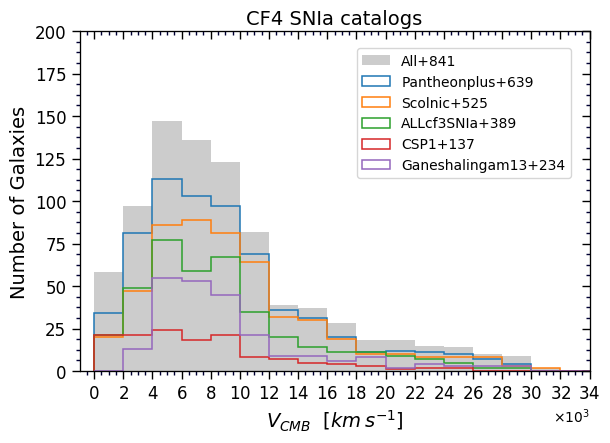

In [19]:
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

bins=np.arange(0,36000,2000)

val = df.Vcmb.values
ax.hist(val, bins=bins, histtype='bar', label='All+'+str(len(val)), color='k', lw=1.7, alpha=0.2) 

val = df[~df["Vcmb_scol20"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='Pantheonplus+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_scolnic"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='Scolnic+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_ALLcf3SNIa"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='ALLcf3SNIa+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_csp1"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='CSP1+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_ganesh"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='Ganeshalingam13+'+str(len(val)), lw=1.1) 

x_ax, y_ax = set_axes(ax, [-1000,34000], [0,200], fontsize=12, inout='out')


ax.set_xlabel(r"$V_{CMB}$"+"  "+r'$[km \/ s^{-1}]$', fontsize=14)
ax.set_ylabel("Number of Galaxies", fontsize=14)

ax.legend(bbox_to_anchor=(0.53, 0.97), loc='upper left', fontsize=10)

x_ax.set_xticks(np.arange(0, 36000, step=2000))
ax.set_xticks(np.arange(0, 36000, step=2000))


ax.set_title("CF4 SNIa catalogs", fontsize=14, pad=5)

ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
ax.ticklabel_format(axis='x', style='sci')

In [20]:
import copy

df_all = copy.deepcopy(df)



In [21]:
import sys
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import  lines
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Polygon, Ellipse
import numpy as np
from math import *
from time import time
import wl_to_rgb as col
import random
from astropy.io import ascii
from astropy.table import Table, Column 
import pyfits
import pylab as py
from astropy import coordinates as coord
from astropy import units as unit
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches

from matplotlib import *

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [22]:
df = df_all # [df_all["Vgrp"]<16000]

vel = df.Vcmb.values
vel = df.Vgrp.values

print np.min(vel), np.max(vel)


-346.3269780845767 31105.57674747171


In [23]:
len(df)

841

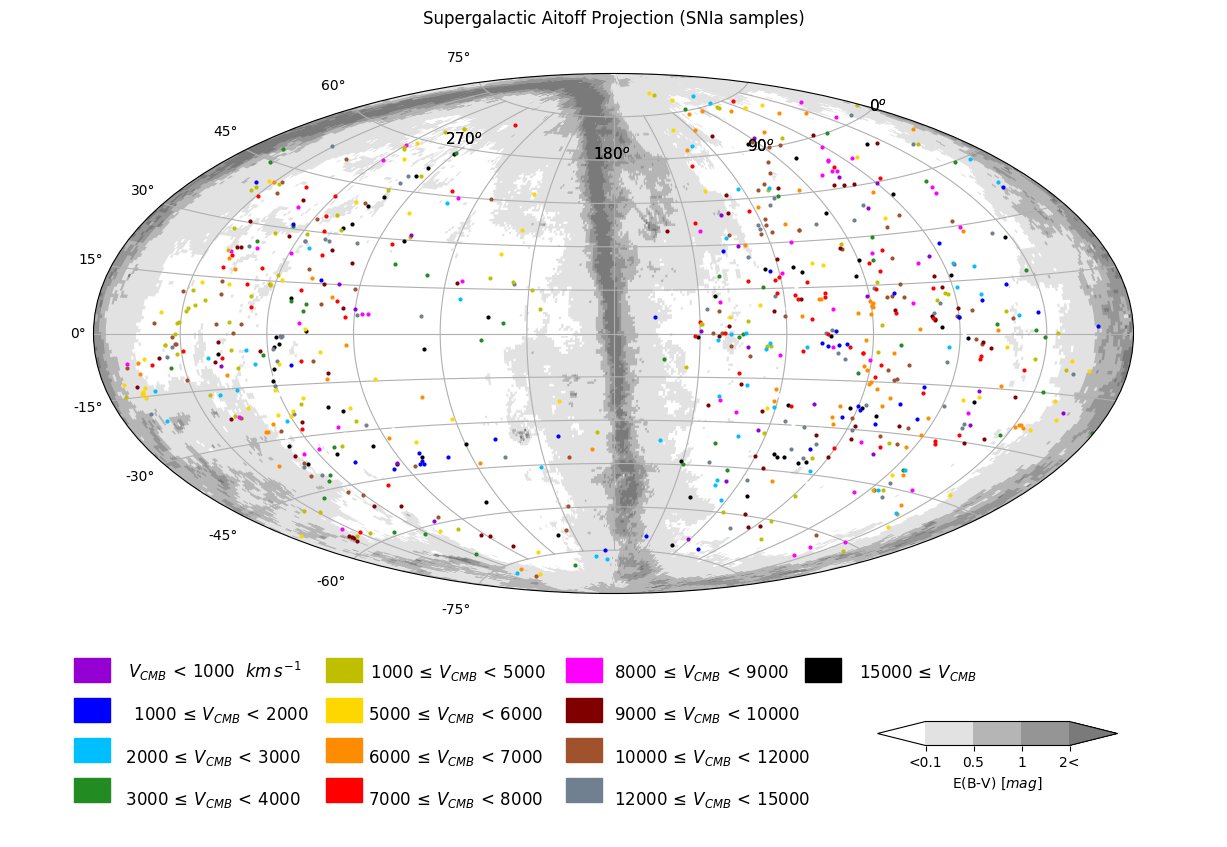

In [24]:
l0 = 180

deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')
d = a[1].data


SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
plt.title("Supergalactic Aitoff Projection (SNIa samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')


ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))


jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)

    
    
# N = len(SGL)
# X = np.zeros(N)
# Y = np.zeros(N)
# for i in range(N):
#     X[i], Y[i] = xymap_aitoff(SGL[i], SGB[i])    
# ax.scatter(X, Y, marker='.', color='black')


sgl_gal = df.sgl.values
sgb_gal = df.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
    
############################################
    
# vel_col = np.zeros(N)   
# Velocity = df.Vcmb.values
# for i, v in enumerate(vel):
#     vel_col[i] = 0
#     if v<=0:
#         vel_col[i] = 0.1
#     elif v>=11000:
#         vel_col[i] = 1
#     else:
#         vel_col[i] = 0.1+0.9*v/11000.
    
# colours = pl.cm.nipy_spectral(vel_col)

############################################
col_pallet = ['darkviolet', 'blue', 'deepskyblue', 'forestgreen', 'y', 'gold', 'darkorange', 'red', 'magenta', 'maroon', 'sienna', 'slategrey', 'black']
vel_pallet = [-100000, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 15000, 20000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

colours = color_table(df.Vgrp.values)
############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ V_{CMB} \/ < \/ 1000 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 1000 \/ \leq \/ V_{CMB} \/ < \/ 2000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 2000 \/ \leq \/ V_{CMB} \/ < \/ 3000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 3000 \/ \leq \/ V_{CMB} \/ < \/ 4000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 1000 \/ \leq \/ V_{CMB} \/ < \/ 5000$', (0.30,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$5000 \/ \leq \/ V_{CMB} \/ < \/ 6000$', (0.30,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$6000 \/ \leq \/ V_{CMB} \/ < \/ 7000$', (0.30,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$7000 \/ \leq \/ V_{CMB} \/ < \/ 8000$', (0.30,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$8000 \/ \leq \/ V_{CMB} \/ < \/ 9000$', (0.5,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$9000 \/ \leq \/ V_{CMB} \/ < \/ 10000$', (0.5,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$10000 \/ \leq \/ V_{CMB} \/ < \/ 12000$', (0.5,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$12000 \/ \leq \/ V_{CMB} \/ < \/ 15000$', (0.5,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$15000 \/ \leq \/ V_{CMB}$', (0.7,0.2), xycoords='figure fraction', size=12, color='black')

p = 0
for m in [0.1,0.31,0.51]:
    for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
        ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
        p+=1
ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))
############################################
################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]
#cols.append(scalarMap.to_rgba(0))
cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))
#cols.append(scalarMap.to_rgba(3.0))



cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   



# ax.scatter(X, Y, color=colours, marker='.', s=3)

for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='.', ms=4)
    